In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [15]:
data_path = "/home/roger/Desktop/surprise-adaptive-agents/paper_runs/runs"
exps = os.listdir(data_path)
reward_results = {}
surprise_results = {}

key_to_plot = "ep_return" # could be "ep_return", "ep_length", "ep_surprise", "ep_entropy"

for exp in exps:
    if "MinAtar" in exp:
        continue
    
    if os.path.isdir(os.path.join(data_path, exp)):
        
        #join all words but the last _seed:1
        exp_name = "_".join(exp.split("_")[:-1])
        
        if exp_name not in reward_results:
            reward_results[exp_name] = []
            surprise_results[exp_name] = []
            
        file = os.path.join(data_path, exp, "log.csv")
        reward_data = pd.read_csv(file)
        reward_results[exp_name].append(reward_data["ep_return"])
        surprise_results[exp_name].append(reward_data["ep_surprise"])

        # for tetris, instead, overwrite the return with =1 if ep_length > 500 and =0 otherwise
        if "tetris" in exp and key_to_plot == "ep_return":
            reward_results[exp_name][-1] = (reward_data["ep_length"] > 100).astype(int)


In [16]:
# make sure for each key in results, all the lists of rewards in the key are of the same length (which should be the max length common to all)
min_lens = {}
for key in reward_results:
    min_len = min([len(x) for x in reward_results[key]])
    reward_results[key] = [x[:min_len] for x in reward_results[key]]
    surprise_results[key] = [x[:min_len] for x in surprise_results[key]]
    min_lens[key] = min_len

In [17]:
# select only X points
num_points = 30
for key in reward_results.keys():
    try:
        reward_results[key] = np.array(reward_results[key])
        indices = np.linspace(0, reward_results[key].shape[1]-1, num_points, dtype=int)
        reward_results[key] = reward_results[key][:, indices]
        surprise_results[key] = np.array(surprise_results[key])
        surprise_results[key] = surprise_results[key][:, indices]
    except:
        print(key)
        print(reward_results[key].shape)

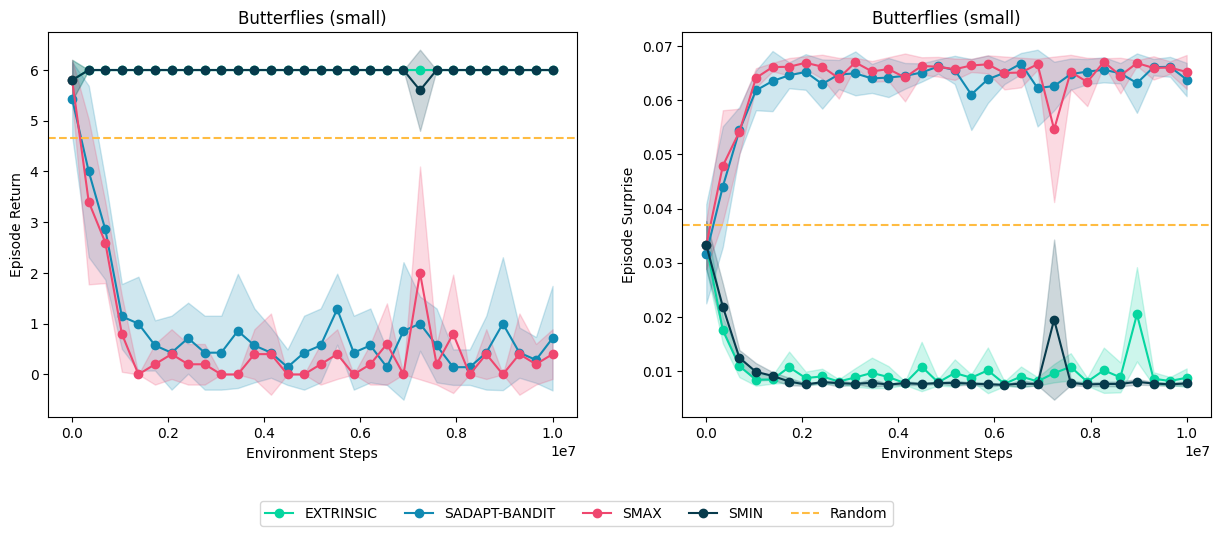

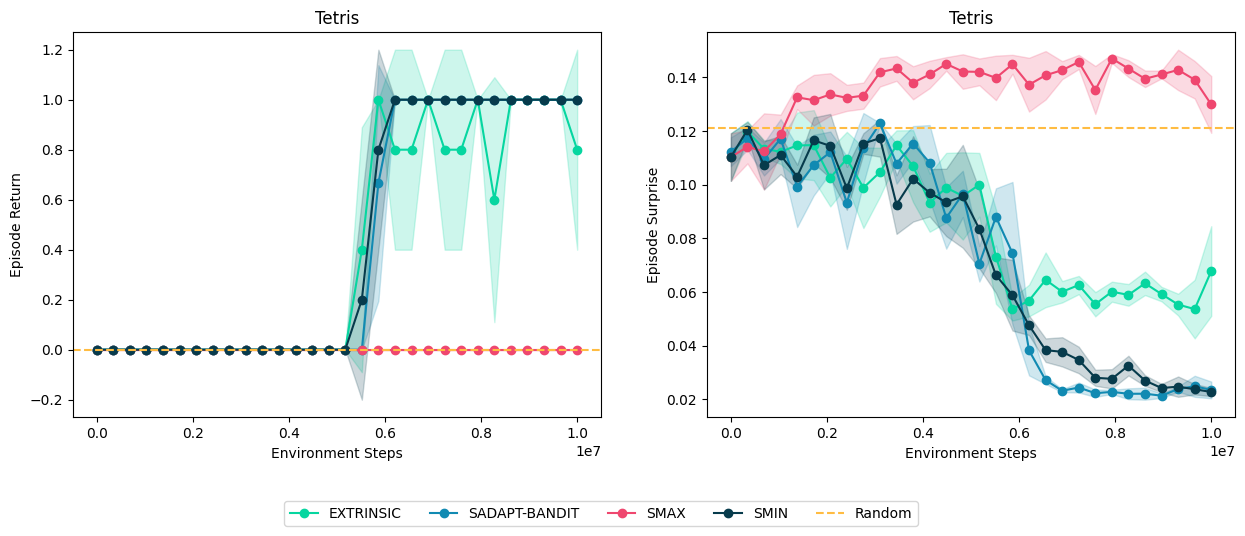

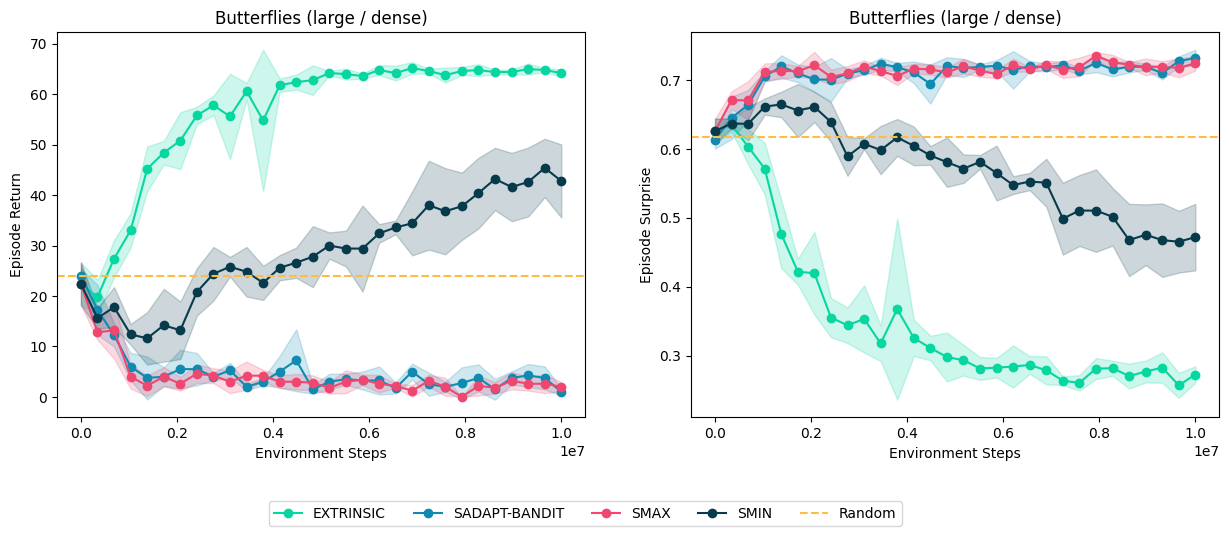

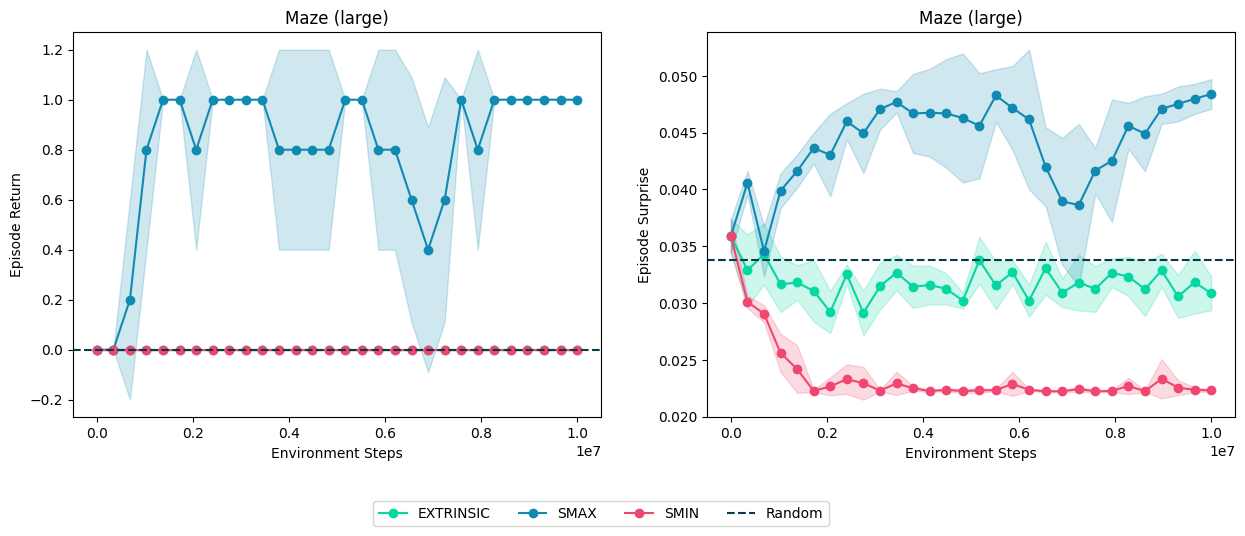

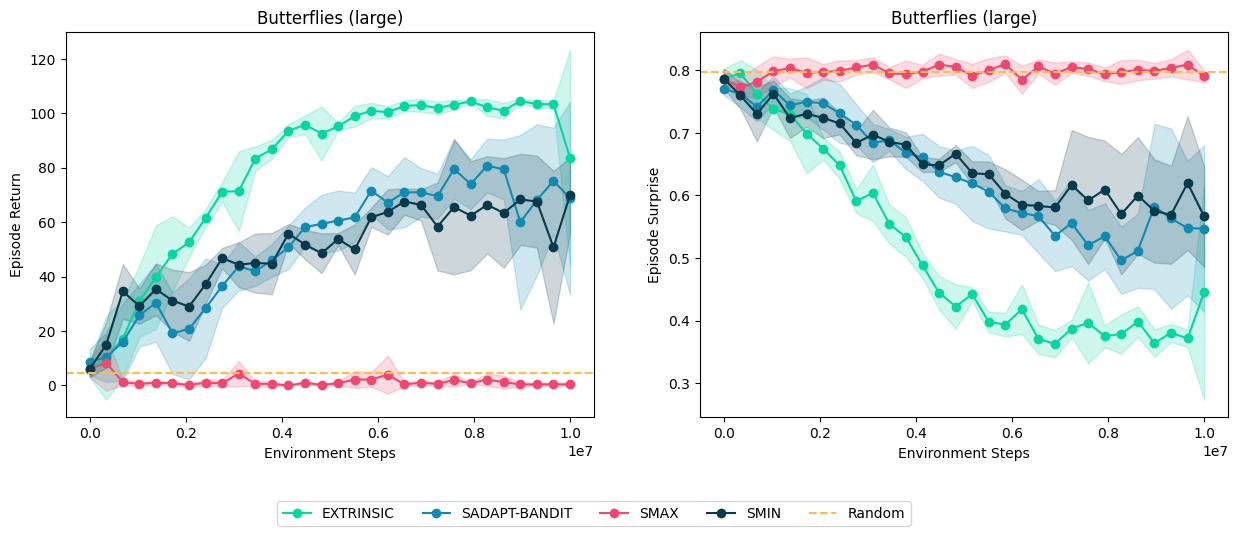

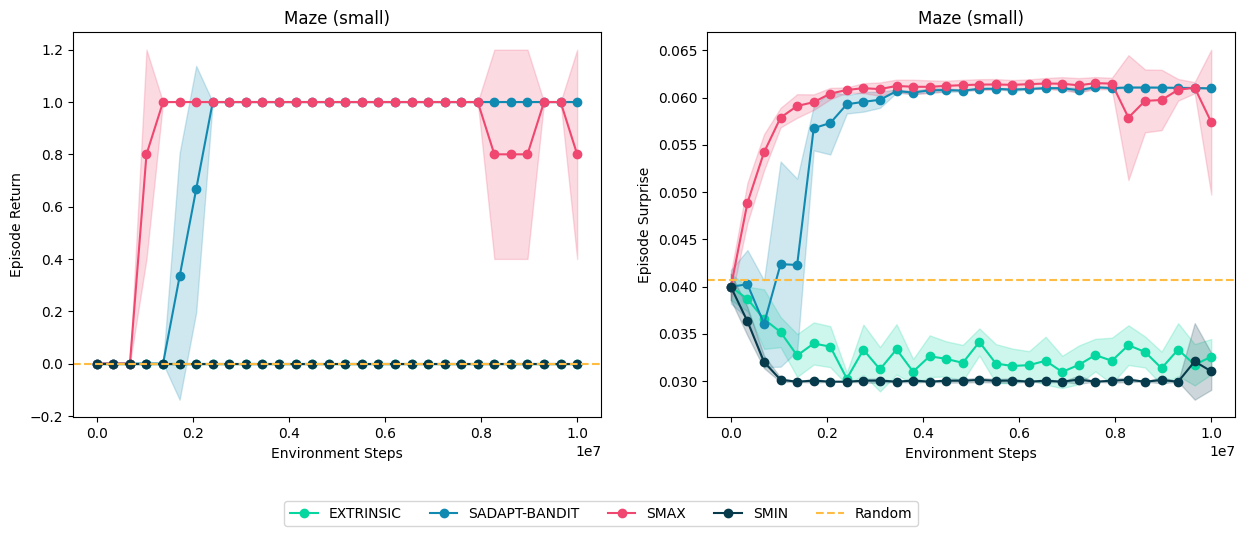

In [18]:
env_names = ["ButterfliesEnv", "tetris", "ButterfliesEnvLarge", "MazeEnvLarge2", "ButterfliesEnvLarge2", "MazeEnv2"]
# one color for S-Max, S-Min, Extrinisc, S-Adapt
colors = ["#06d6a0", "#118ab2", "#ef476f", "#073b4c", "#ffbc42"]

for env in env_names:
    fig, ax = plt.subplots(1,2, figsize=(15, 5))
    idx_ = 0
    for exp in sorted(reward_results):
        if env not in exp or \
            (env == "MazeEnv" and ("MazeEnvLarge" in exp or "MazeEnvLarge2" in exp or "MazeEnv2" in exp)) or (env == "ButterfliesEnv" and ("ButterfliesEnvLarge" in exp or "ButterfliesEnvLarge2" in exp)) \
            or \
            (env == "MazeEnvLarge" and ("MazeEnv2" in exp or "MazeEnvLarge2" in exp)) or (env == "ButterfliesEnvLarge" and ("ButterfliesEnv2" in exp or "ButterfliesEnvLarge2" in exp)):
            continue
        
        if "random" in exp:
            exp_name = "Random"
        else:
            exp_name = exp.split("_")[2].upper()

        if exp_name == "NONE": exp_name = "EXTRINSIC"
        
        if key_to_plot == "ep_return":
            metric_title = "Episode Return"
        elif key_to_plot == "ep_surprise":
            metric_title = "Episode Surprise"
        elif key_to_plot == "ep_entropy":
            metric_title = "Episode Entropy"
        elif key_to_plot == "ep_length":
            metric_title = "Episode Length"
        else:
            raise ValueError("Invalid key_to_plot")
        
        env_title = env.capitalize()
        
        if env_title == "Butterfliesenv":
            env_title = "Butterflies (small)"
        elif env_title == "Butterfliesenvlarge":
            env_title = "Butterflies (large / dense)"
        elif env_title == "Butterfliesenvlarge2":
            env_title = "Butterflies (large)"
        elif env_title == "Mazeenv2":
            env_title = "Maze (small)"
        elif env_title == "Mazeenvlarge2":
            env_title = "Maze (large)"
        elif env_title == "Tetris":
            env_title = "Tetris"
        else:
            print(env_title)
            raise ValueError("Invalid env_title")
        
        if exp_name == "Random":
            # just compute the mean line which we will plot as a horizontal line
            mean = reward_results[exp].mean(axis=0)
            mean_surprise = surprise_results[exp].mean(axis=0)
            x_axis = np.linspace(0, 10_000_000, num_points)
            
            ax[0].axhline(y=mean[-1], color=colors[idx_], linestyle="--", label=exp_name)
            ax[1].axhline(y=mean_surprise[-1], color=colors[idx_], linestyle="--", label=exp_name)
        else:
            mean = reward_results[exp].mean(axis=0)
            std = reward_results[exp].std(axis=0)

            mean_surprise = surprise_results[exp].mean(axis=0)
            std_surprise = surprise_results[exp].std(axis=0)

            x_axis = np.linspace(0, 10_000_000, num_points)
            
            ax[0].plot(x_axis, mean, marker="o", label=exp_name, color=colors[idx_])
            ax[0].fill_between(x_axis, mean+std, mean-std, alpha=0.2, color=colors[idx_])
            ax[1].plot(x_axis, mean_surprise, marker="o", label=exp_name, color=colors[idx_])
            ax[1].fill_between(x_axis, mean_surprise+std_surprise, mean_surprise-std_surprise, alpha=0.2, color=colors[idx_])

        # only 1 legend, center bottom outside of plot
        ax[0].legend(loc='center', bbox_to_anchor=(1, -0.25), ncol=5)
        
        ax[0].set_title(env_title)
        ax[0].set_xlabel("Environment Steps")
        ax[0].set_ylabel("Episode Return")
        ax[1].set_title(env_title)
        ax[1].set_xlabel("Environment Steps")
        ax[1].set_ylabel("Episode Surprise")
        idx_ += 1

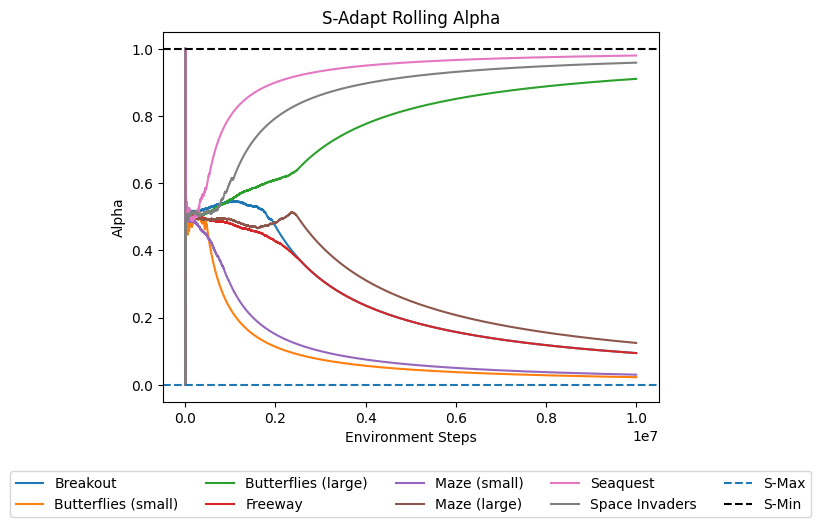

In [41]:
### rolling alphas
data_path = os.listdir("/home/roger/Desktop/surprise-adaptive-agents/paper_runs/rolling_alphas")
for run in sorted(data_path):
    file=os.path.join("/home/roger/Desktop/surprise-adaptive-agents/paper_runs/rolling_alphas", run)
    data = pd.read_csv(file)
    #alphas is the last column
    alpha = data.iloc[:,-1]
    
    # run_name
    run_name = run
    run_name = run_name.replace(".csv", "")
    if run_name == "maze_env2": run_name = "Maze (small)"
    elif run_name == "maze_large_env2": run_name = "Maze (large)"
    elif run_name == "butterfliesEnv": run_name = "Butterflies (small)"
    elif run_name == "butterflies_large2": run_name = "Butterflies (large)"
    elif run_name == "tetris": run_name = "Tetris"
    elif run_name == "breakout": run_name = "Breakout"
    elif run_name == "seaquest": run_name = "Seaquest"
    elif run_name == "space_invaders": run_name = "Space Invaders"
    elif run_name == "freeway": run_name = "Freeway"
    
    x_axis = np.linspace(0, 10_000_000, len(alpha))
    plt.title("S-Adapt Rolling Alpha")
    plt.xlabel("Environment Steps")
    plt.ylabel("Alpha")
    plt.plot(x_axis, alpha, label=run_name)
    
# add smax label in in y=0 and smin label in y=1
plt.axhline(y=0, linestyle="--", label="S-Max")
plt.axhline(y=1, color="black", linestyle="--", label="S-Min")
# make medium size
plt.legend(loc='center', bbox_to_anchor=(0.5, -0.25), ncol=5)
        